In [1]:
import numpy as np
%load_ext autoreload
%autoreload 2

import datetime
import random
import utils

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
from kneed import KneeLocator
from sklearn.cluster import KMeans

random.seed(42)

# 1. Load data 

Load data either from downloaded CSV or via REST API.

Data loaded from API is slightly different from the data from CSV, so it needs to be aligned to fit the CSV data.

In [2]:

# basic configurations
READ_FROM_API = False


# load data
if READ_FROM_API:
    CRED_FILE = "credentials.json"
    df_json = utils.read_from_web(CRED_FILE)
else:
    FILE = "data/Events-Match_Test__TEAM_A_vs__TEAM_B-Period_Period_1_Period_Period_2_Period_Period_3.csv"
    EVENT_TYPE = "Shifts"
    
    # load initial dataset
    df = utils.read_file(FILE, EVENT_TYPE)
    

print("Data Frame loaded successfully!")
df


Data Frame loaded successfully!


,Timestamp (ms),Timestamp in local format,Player ID,Name,Event type,Duration (s),Distance,Distance (speed | Very low),Distance (speed | Low),Distance (speed | Medium),Distance (speed | High),Distance (speed | Very high),Distance (speed | Sprint),Distance (speed | 0 - 0 km/h),Metabolic Power (Ø),Speed (max.),Skating Load,Skating Intensity
0,1670697995000,12/10/2022;07:46:35.000 PM,438,D TEST,Shift,34.707001,114.0,29.0,15,25,36,9,0.0,NaN,337.08,22.60,21.67,37.45
1,1670697995000,12/10/2022;07:46:35.000 PM,443,D TEST,Shift,43.952999,177.0,25.0,21,39,51,36,4.0,NaN,413.47,24.34,28.74,39.24
4,1670697995000,12/10/2022;07:46:35.000 PM,470,D3 Guest,Shift,82.765999,288.0,45.0,83,70,87,3,0.0,NaN,0.00,21.88,51.74,37.51
7,1670697995000,12/10/2022;07:46:35.000 PM,471,D4 Guest,Shift,57.615002,215.0,34.0,29,59,79,14,0.0,NaN,0.00,21.75,46.27,48.18
11,1670697995000,12/10/2022;07:46:35.000 PM,448,FW TEST,Shift,20.010000,1.0,1.0,0,0,0,0,0.0,NaN,9.93,4.64,0.49,1.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13052,1670705504000,12/10/2022;09:51:44.000 PM,455,FW TEST,Shift,14.317000,30.0,12.0,8,0,3,7,0.0,NaN,356.84,21.82,0.84,3.50
13085,1670705547000,12/10/2022;09:52:27.000 PM,441,D TEST,Shift,3.623000,1.0,1.0,0,0,0,0,0.0,NaN,62.98,4.88,1.34,22.15
13086,1670705547000,12/10/2022;09:52:27.000 PM,450,FW TEST,Shift,3.623000,5.0,5.0,0,0,0,0,0.0,NaN,150.85,8.24,2.60,43.10
13087,1670705547000,12/10/2022;09:52:27.000 PM,453,FW TEST,Shift,3.588000,3.0,3.0,0,0,0,0,0.0,NaN,136.72,9.65,2.40,40.19


# 2. Experiment with Intensities

Try different configurations ond see how to best calculate the intensities of different shifts.

In [3]:
# Generate dataset
df_no_keepers = df[~df["Name"].str.contains("Goalkeeper")]
df_no_keepers = df_no_keepers[df_no_keepers["Name"].str.contains("Guest")]

## 2.1 Intensities of Individual Players

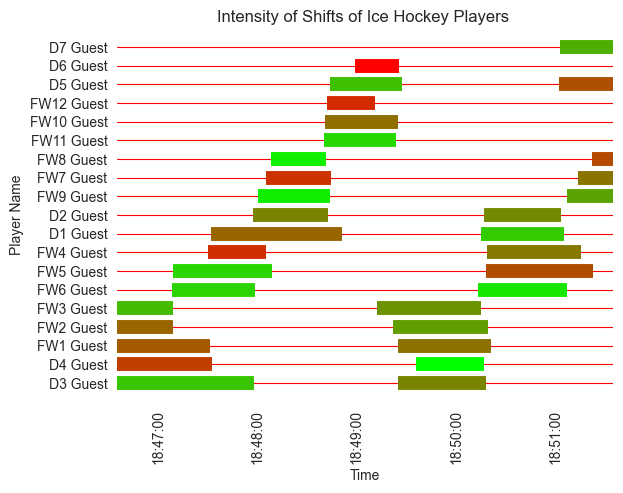

,timestamp,time,Timestamp (ms),Duration (s),Name,Skating Intensity,relative_intensity
4,2022-12-10 18:46:35,0 days 00:01:22.765999,1670697995000,82.765999,D3 Guest,37.51,0.222499
7,2022-12-10 18:46:35,0 days 00:00:57.615002,1670697995000,57.615002,D4 Guest,48.18,0.753609
18,2022-12-10 18:46:35,0 days 00:00:56.131001,1670697995000,56.131001,FW1 Guest,46.07,0.648581
19,2022-12-10 18:46:35,0 days 00:00:33.981998,1670697995000,33.981998,FW2 Guest,45.19,0.604778
21,2022-12-10 18:46:35,0 days 00:00:33.499001,1670697995000,33.499001,FW3 Guest,38.47,0.270284
155,2022-12-10 18:47:08,0 days 00:00:50.438999,1670698028000,50.438999,FW6 Guest,36.44,0.169238
159,2022-12-10 18:47:09,0 days 00:00:59.375000,1670698029000,59.375000,FW5 Guest,36.21,0.157790
242,2022-12-10 18:47:30,0 days 00:00:35.120998,1670698050000,35.120998,FW4 Guest,49.45,0.816824
250,2022-12-10 18:47:32,0 days 00:01:19.073997,1670698052000,79.073997,D1 Guest,45.10,0.600299
370,2022-12-10 18:47:57,0 days 00:00:45.229000,1670698077000,45.229000,D2 Guest,42.73,0.482330


In [8]:
block_config = None

utils.plot_shifts_with_intensity_individual(df_no_keepers, block_config=block_config)

## 2.2 Intensities for Blocks using elbow-method

Here we see, that there is at least 1 block with too many players.

ELBOW METHOD


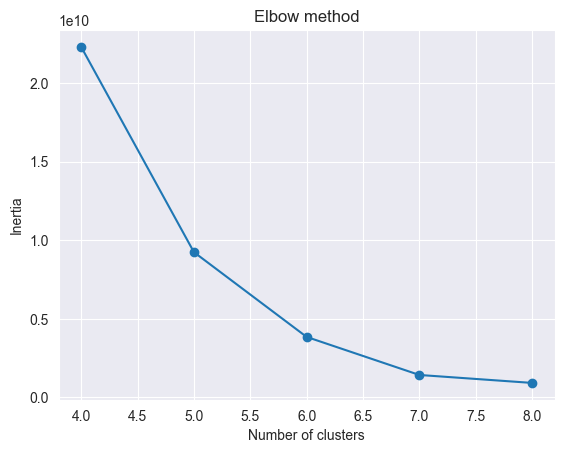

Knee, i.e. calculated number of shifts, is at: 6
Summary of all Shifts. Points are the individual players. Colors are their blocks.


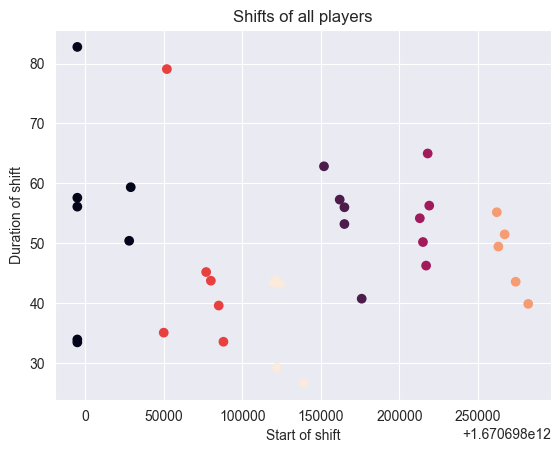

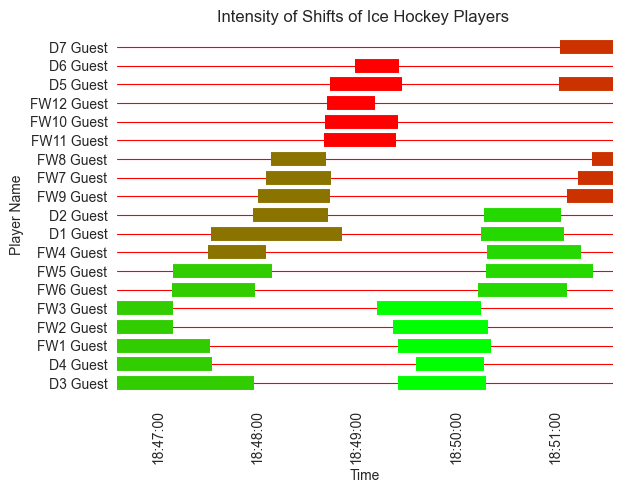

,timestamp,time,Timestamp (ms),Duration (s),Name,Skating Intensity,Shift_Label,relative_intensity
4,2022-12-10 18:46:35,0 days 00:01:22.765999,1670697995000,82.765999,D3 Guest,37.51,0,0.194940
7,2022-12-10 18:46:35,0 days 00:00:57.615002,1670697995000,57.615002,D4 Guest,48.18,0,0.194940
18,2022-12-10 18:46:35,0 days 00:00:56.131001,1670697995000,56.131001,FW1 Guest,46.07,0,0.194940
19,2022-12-10 18:46:35,0 days 00:00:33.981998,1670697995000,33.981998,FW2 Guest,45.19,0,0.194940
21,2022-12-10 18:46:35,0 days 00:00:33.499001,1670697995000,33.499001,FW3 Guest,38.47,0,0.194940
155,2022-12-10 18:47:08,0 days 00:00:50.438999,1670698028000,50.438999,FW6 Guest,36.44,0,0.194940
159,2022-12-10 18:47:09,0 days 00:00:59.375000,1670698029000,59.375000,FW5 Guest,36.21,0,0.194940
242,2022-12-10 18:47:30,0 days 00:00:35.120998,1670698050000,35.120998,FW4 Guest,49.45,3,0.545486
250,2022-12-10 18:47:32,0 days 00:01:19.073997,1670698052000,79.073997,D1 Guest,45.10,3,0.545486
370,2022-12-10 18:47:57,0 days 00:00:45.229000,1670698077000,45.229000,D2 Guest,42.73,3,0.545486


In [11]:
block_config = {
    "naive_number_of_shifts" : False,
    "verbose": True
}

utils.plot_shifts_with_intensity_individual(df_no_keepers, block_config=block_config)

## 2.3 Intensities for Blocks using naive approach

The shifts make sense, even though there is an overlap for player D1 Guest.

NAIVE METHOD
Number of rows in dataset = 33
Probable number of shifts = 7
Summary of all Shifts. Points are the individual players. Colors are their blocks.


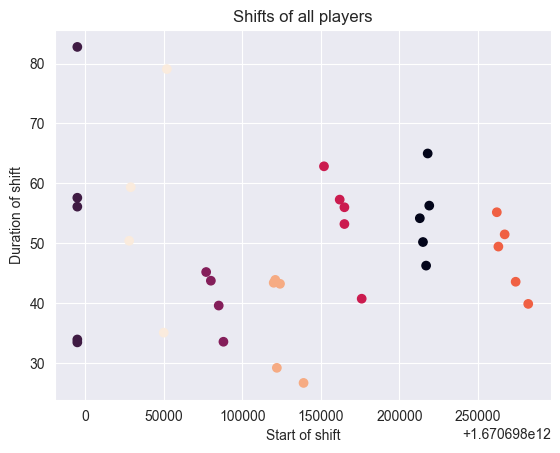

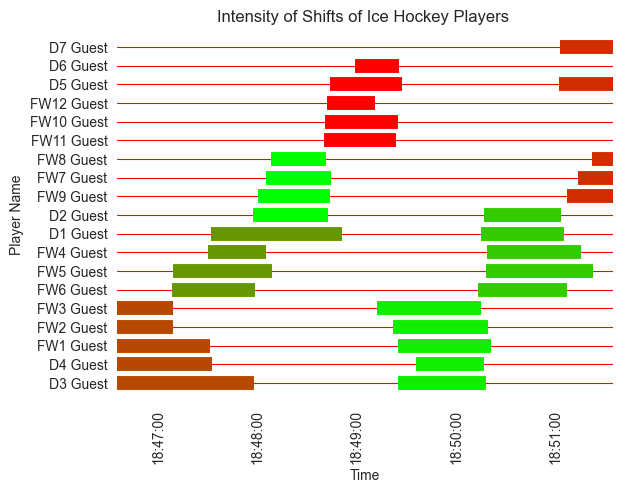

,timestamp,time,Timestamp (ms),Duration (s),Name,Skating Intensity,Shift_Label,relative_intensity
4,2022-12-10 18:46:35,0 days 00:01:22.765999,1670697995000,82.765999,D3 Guest,37.51,1,0.715425
7,2022-12-10 18:46:35,0 days 00:00:57.615002,1670697995000,57.615002,D4 Guest,48.18,1,0.715425
18,2022-12-10 18:46:35,0 days 00:00:56.131001,1670697995000,56.131001,FW1 Guest,46.07,1,0.715425
19,2022-12-10 18:46:35,0 days 00:00:33.981998,1670697995000,33.981998,FW2 Guest,45.19,1,0.715425
21,2022-12-10 18:46:35,0 days 00:00:33.499001,1670697995000,33.499001,FW3 Guest,38.47,1,0.715425
155,2022-12-10 18:47:08,0 days 00:00:50.438999,1670698028000,50.438999,FW6 Guest,36.44,6,0.405242
159,2022-12-10 18:47:09,0 days 00:00:59.375000,1670698029000,59.375000,FW5 Guest,36.21,6,0.405242
242,2022-12-10 18:47:30,0 days 00:00:35.120998,1670698050000,35.120998,FW4 Guest,49.45,6,0.405242
250,2022-12-10 18:47:32,0 days 00:01:19.073997,1670698052000,79.073997,D1 Guest,45.10,6,0.405242
370,2022-12-10 18:47:57,0 days 00:00:45.229000,1670698077000,45.229000,D2 Guest,42.73,2,0.000000


In [12]:
block_config = {
    "naive_number_of_shifts" : True,
    "verbose": True
}

utils.plot_shifts_with_intensity_individual(df_no_keepers, block_config=block_config)